In [66]:
import pandas as pd
import tensorflow as tf
from keras.datasets import fashion_mnist
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import seaborn as sns
from sklearn.metrics import confusion_matrix
import copy
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
from torch.utils.data import TensorDataset
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F

In [2]:
device = 'cuda'

In [3]:
'''LOADING TRAIN AND TEST DATA SET'''
(x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [5]:
print(x_train[0]) #The values are between 0 and 255(un-normalized)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

In [6]:
'''Finding image of each category'''
categories=[]
images_list=[]
attributes={0:'T-shirt',1:'Trouser',2:'Pullover',3:'Skirt',4:'Overcoat',5:'Sandal',
            6:'Shirt',7:'Sneakers',8:'Bag',9:'Ankle boot'}
title=list(attributes.values())
print(f'The various categorical variables in the data are : {title}')
for i in range(10):
    categories.append(i)
for i in range(y_train.shape[0]):
               if y_train[i]==categories[0]:
                    images_list.append(x_train[i])
                    del(categories[0])
                    if len(categories)==0:
                        break

The various categorical variables in the data are : ['T-shirt', 'Trouser', 'Pullover', 'Skirt', 'Overcoat', 'Sandal', 'Shirt', 'Sneakers', 'Bag', 'Ankle boot']


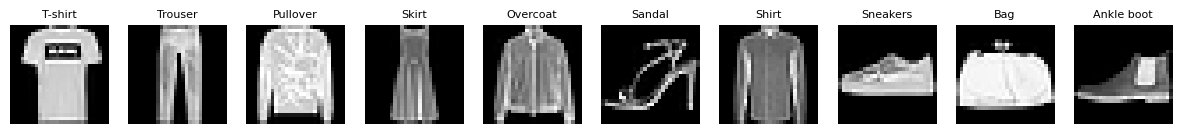

In [7]:
'''Displaying one image per category'''
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 1.5))
for i, (ax, image) in enumerate(zip(axes, images_list)):
    ax.imshow(image, cmap='gray')
    ax.set_title(title[i], fontsize=8)
    ax.axis('off')
plt.show()

In [8]:
'''
We have to convert the ndarray images into PIL images to apply the torchvision.transforms
'''
x_train_pil = [Image.fromarray((image).astype('uint8')) for image in x_train]
x_test_pil = [Image.fromarray((image).astype('uint8')) for image in x_test]

In [9]:
'''
Data Augmentation : Flipping is performed with a 50% probability
                    Rotation is done between -15 and 15 degrees
'''

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),
    transforms.RandomRotation(15)  # Randomly rotates the image by ±15 degrees
])

test_transform = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])


In [10]:
'''Creating tensor datasets using the pre-defined transforms for train and test'''
x_train = [train_transform(image) for image in x_train_pil]
x_test = [test_transform(image) for image in x_test_pil]

In [11]:
x_train = torch.stack(x_train)
x_test = torch.stack(x_test)

In [15]:
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

In [16]:
print(x_train.shape)

torch.Size([60000, 1, 28, 28])


In [20]:
def data_loader(x,y,batch_size,device=device):
    
    x=x.to(device)
    y=y.to(device)
    combined=TensorDataset(x,y)
    loader=DataLoader(combined,batch_size=batch_size,shuffle=False,drop_last=True)
    return loader

In [120]:
'''Creating data loader'''
train_loader = data_loader(x_train, y_train, batch_size = 8, device = device)
test_loader = data_loader(x_test, y_test, batch_size = 8, device = device)

In [121]:
for (x,y) in train_loader:
    print(x.shape)
    break

torch.Size([8, 1, 28, 28])


In [122]:
class LeNet5(nn.Module):

    def __init__(self):
        '''
        nn.Conv2d(in_channels, out_channels, kernel_size, stride,padding,...)
        torch.nn.AvgPool2d(kernel_size, stride=None, padding=0,...)
        '''
        
        super(LeNet5, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5, 1, 0)
        self.pool1 = nn.AvgPool2d(2, 2, 0)
        self.conv2 = nn.Conv2d(6, 16, 5, 1, 0)
        self.pool2 = nn.AvgPool2d(2, 2, 0)
        self.fc1 = nn.Linear(256, 120, bias = True)
        self.fc2 = nn.Linear(120, 84, bias = True)
        self.logits = nn.Linear(84, 10, bias = True)


    def forward(self, x):
        '''
        Input shape : (batchsize, 28, 28)
        Output shape : (batchsize, 10)
        '''
        bs = x.shape[0]
        c = x.shape[1]
        h = x.shape[2]
        w = x.shape[3]
        
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        '''
        We need to flatten the input before passing it through the linear layers
        '''
        x = x.view(bs, -1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        out = self.logits(x)

        return out
        

In [123]:
model = LeNet5()
model = model.to(device)

In [124]:
learning_rate = 0.001
epochs = 30

In [125]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [126]:
def train(model, train_loader, test_loader, loss_fn, epochs, optimizer, device):
    """
    Trains and validates a neural network model.

    Parameters:
        model (torch.nn.Module): The neural network to train.
        train_loader (DataLoader): DataLoader for providing the training data.
        test_loader (DataLoader): DataLoader for providing the validation data.
        loss_fn (callable): The loss function.
        epochs (int): Number of epochs to train the model.
        optimizer (torch.optim.Optimizer): The optimizer for updating model weights.
        device (torch.device): The device to run the training on (e.g., 'cuda' or 'cpu').

    Returns:
        tuple: A tuple containing the average training loss and accuracy.
    """
    for epoch in range(epochs):
        model.train()  # Training mode for Dropout, BatchNorm, etc.
        total_loss, total_acc = 0, 0
        
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch"):
            
            x, y = x.to(device), y.to(device)
            
            pred = model(x)
            loss = loss_fn(pred, y.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_acc += (pred.argmax(1) == y).type(torch.float).mean().item()*100

        avg_train_loss = total_loss / len(train_loader)
        avg_train_acc = total_acc / len(train_loader)

        
        model.eval() 
        total_val_loss, total_val_acc = 0, 0
        with torch.no_grad(): 
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                total_val_loss += loss_fn(pred, y.long()).item()
                total_val_acc += (pred.argmax(1) == y).type(torch.float).mean().item()*100

        avg_val_loss = total_val_loss / len(test_loader)
        avg_val_acc = total_val_acc / len(test_loader)

        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")

    return avg_train_loss, avg_train_acc


In [127]:
epoch_loss = train(model, train_loader, test_loader, loss, epochs, optimizer, device)
print(f'Training loss: {epoch_loss}')

Epoch 1/30: 100%|███████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 594.75batch/s]


Train Loss: 0.7352, Train Acc: 71.4050, Val Loss: 0.6014, Val Acc: 76.2800


Epoch 2/30: 100%|███████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 601.23batch/s]


Train Loss: 0.5300, Train Acc: 80.2400, Val Loss: 0.5300, Val Acc: 80.2000


Epoch 3/30: 100%|███████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 591.25batch/s]


Train Loss: 0.4631, Train Acc: 82.6183, Val Loss: 0.5081, Val Acc: 81.4700


Epoch 4/30: 100%|███████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 581.41batch/s]


Train Loss: 0.4229, Train Acc: 84.2150, Val Loss: 0.4544, Val Acc: 83.2300


Epoch 5/30: 100%|███████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 584.94batch/s]


Train Loss: 0.3945, Train Acc: 85.2433, Val Loss: 0.4700, Val Acc: 82.8400


Epoch 6/30: 100%|███████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 602.29batch/s]


Train Loss: 0.3741, Train Acc: 85.9433, Val Loss: 0.4463, Val Acc: 84.1300


Epoch 7/30: 100%|███████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 603.15batch/s]


Train Loss: 0.3547, Train Acc: 86.6133, Val Loss: 0.4534, Val Acc: 84.0600


Epoch 8/30: 100%|███████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 591.17batch/s]


Train Loss: 0.3386, Train Acc: 87.1717, Val Loss: 0.4385, Val Acc: 84.8600


Epoch 9/30: 100%|███████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 590.80batch/s]


Train Loss: 0.3248, Train Acc: 87.7950, Val Loss: 0.4613, Val Acc: 84.8000


Epoch 10/30: 100%|██████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 579.71batch/s]


Train Loss: 0.3120, Train Acc: 88.0883, Val Loss: 0.4810, Val Acc: 84.6000


Epoch 11/30: 100%|██████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 581.15batch/s]


Train Loss: 0.3006, Train Acc: 88.4267, Val Loss: 0.4862, Val Acc: 84.9500


Epoch 12/30: 100%|██████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 580.34batch/s]


Train Loss: 0.2914, Train Acc: 88.8567, Val Loss: 0.5084, Val Acc: 85.2600


Epoch 13/30: 100%|██████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 583.84batch/s]


Train Loss: 0.2827, Train Acc: 89.1383, Val Loss: 0.5330, Val Acc: 85.2300


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 587.04batch/s]


Train Loss: 0.2743, Train Acc: 89.4850, Val Loss: 0.5538, Val Acc: 84.1800


Epoch 15/30: 100%|██████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 590.94batch/s]


Train Loss: 0.2688, Train Acc: 89.7433, Val Loss: 0.5429, Val Acc: 85.3400


Epoch 16/30: 100%|██████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 589.69batch/s]


Train Loss: 0.2606, Train Acc: 89.9600, Val Loss: 0.5533, Val Acc: 85.2300


Epoch 17/30: 100%|██████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 595.52batch/s]


Train Loss: 0.2535, Train Acc: 90.4367, Val Loss: 0.5974, Val Acc: 84.6800


Epoch 18/30: 100%|██████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 583.08batch/s]


Train Loss: 0.2481, Train Acc: 90.2167, Val Loss: 0.5948, Val Acc: 85.0200


Epoch 19/30: 100%|██████████████████████████████████████████████████████████████| 7500/7500 [00:13<00:00, 573.79batch/s]


Train Loss: 0.2432, Train Acc: 90.6633, Val Loss: 0.5871, Val Acc: 84.7800


Epoch 20/30: 100%|██████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 578.77batch/s]


Train Loss: 0.2386, Train Acc: 90.7833, Val Loss: 0.6378, Val Acc: 84.6100


Epoch 21/30: 100%|██████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 584.01batch/s]


Train Loss: 0.2348, Train Acc: 90.9133, Val Loss: 0.6336, Val Acc: 85.1900


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 587.30batch/s]


Train Loss: 0.2296, Train Acc: 91.1617, Val Loss: 0.6211, Val Acc: 84.7100


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 583.74batch/s]


Train Loss: 0.2264, Train Acc: 91.3183, Val Loss: 0.6421, Val Acc: 85.1000


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 596.99batch/s]


Train Loss: 0.2207, Train Acc: 91.4350, Val Loss: 0.6337, Val Acc: 84.5800


Epoch 25/30: 100%|██████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 588.20batch/s]


Train Loss: 0.2148, Train Acc: 91.8550, Val Loss: 0.6721, Val Acc: 85.0400


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████| 7500/7500 [00:13<00:00, 573.57batch/s]


Train Loss: 0.2131, Train Acc: 91.8550, Val Loss: 0.6626, Val Acc: 84.8500


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 588.59batch/s]


Train Loss: 0.2154, Train Acc: 91.7317, Val Loss: 0.6972, Val Acc: 84.4700


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 592.46batch/s]


Train Loss: 0.2042, Train Acc: 92.1733, Val Loss: 0.7035, Val Acc: 85.1100


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████| 7500/7500 [00:12<00:00, 589.93batch/s]


Train Loss: 0.2008, Train Acc: 92.2317, Val Loss: 0.7563, Val Acc: 84.4600


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████| 7500/7500 [00:13<00:00, 576.84batch/s]


Train Loss: 0.2029, Train Acc: 92.2300, Val Loss: 0.7489, Val Acc: 84.8100
Training loss: (0.20291823792932398, 92.23)
